In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
import cv2
import os
import sklearn

In [3]:
# Creating dataframe by iterating through filepaths
import pathlib 
pneumonia_dir = pathlib.Path("chest_xray/chest_xray/train/PNEUMONIA/")
normal_dir = pathlib.Path("chest_xray/chest_xray/train/NORMAL/")

In [4]:
dirlist=[pneumonia_dir,normal_dir ]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  5216    labels:  5216


In [5]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(5216,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,chest_xray\chest_xray\train\PNEUMONIA\person10...,No
1,chest_xray\chest_xray\train\PNEUMONIA\person10...,No
2,chest_xray\chest_xray\train\PNEUMONIA\person10...,No
3,chest_xray\chest_xray\train\PNEUMONIA\person10...,No
4,chest_xray\chest_xray\train\PNEUMONIA\person10...,No


In [6]:
print(df['labels'].value_counts())

No     3875
Yes    1341
Name: labels, dtype: int64


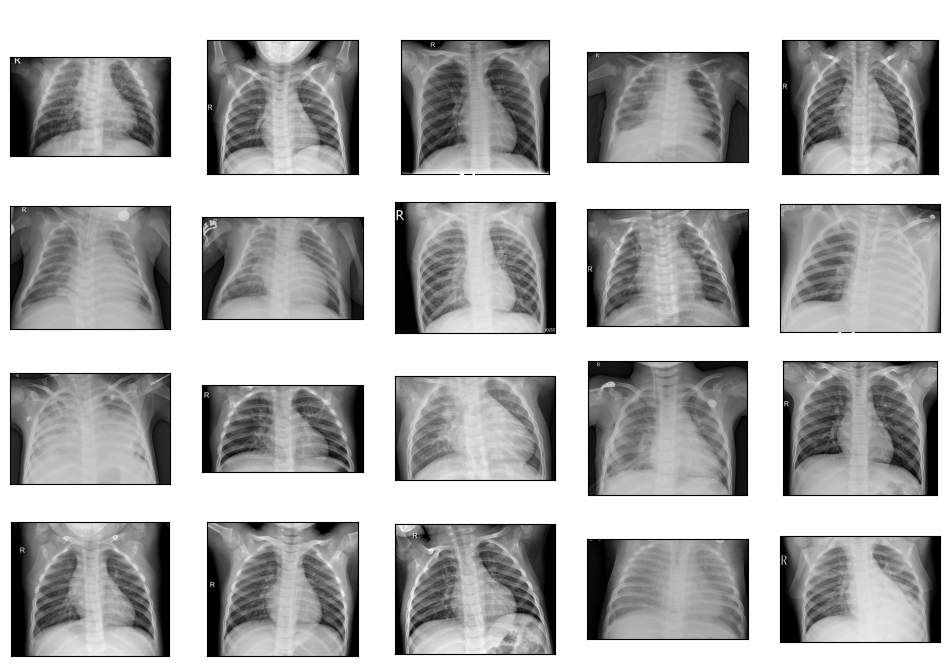

In [7]:
plt.figure(figsize=(12,8))
for i in range(20):
    random = np.random.randint(1,len(df))
    plt.subplot(4,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 20, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [8]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [9]:
import glob
images_dict = {
    'pnuemonia': list(pneumonia_dir.glob('*')) ,   
    'normal': list(normal_dir.glob('*'))  
}

labels_dict = {
    'pnuemonia': "pnuemonia",
    'normal': "normal",
    
}

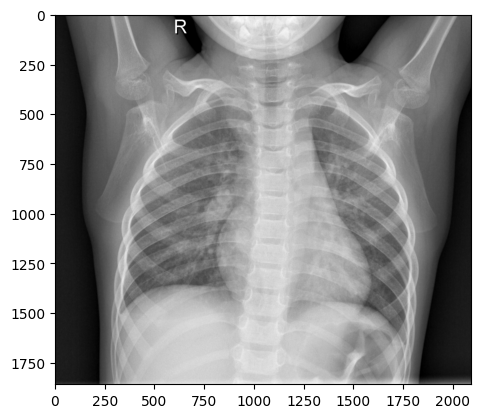

In [9]:
import PIL.Image as Image
from keras.preprocessing.image import ImageDataGenerator
img = cv2.imread(str(images_dict['normal'][0]))
plt.imshow(img)




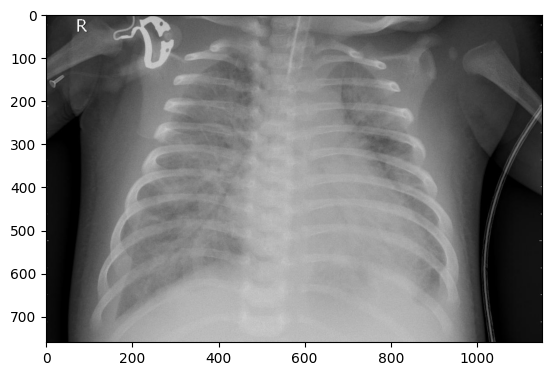

In [10]:
img2 = cv2.imread(str(images_dict['pnuemonia'][0]))
plt.imshow(img2)

In [11]:
X, y = [], []
for name,images in images_dict.items():#returns key , path for each record
    for image in images:
        img=str(image)
     
        #resize_img=cv2.resize(img)
       
        X.append(img)
        y.append(labels_dict[name])

In [12]:
Fseries = pd.Series(X, name="filepaths",dtype=str)
Lseries = pd.Series(y, name="labels",dtype=str)
pneumonia_data = pd.concat([Fseries,Lseries], axis=1)
pneumonia_df = pd.DataFrame(pneumonia_data)

print(pneumonia_df.head())
print("---------------------")
print(pneumonia_df["labels"].value_counts())

                                           filepaths     labels
0  chest_xray\chest_xray\train\PNEUMONIA\person10...  pnuemonia
1  chest_xray\chest_xray\train\PNEUMONIA\person10...  pnuemonia
2  chest_xray\chest_xray\train\PNEUMONIA\person10...  pnuemonia
3  chest_xray\chest_xray\train\PNEUMONIA\person10...  pnuemonia
4  chest_xray\chest_xray\train\PNEUMONIA\person10...  pnuemonia
---------------------
pnuemonia    3875
normal       1341
Name: labels, dtype: int64


In [13]:
pneumonia_df.shape

(5216, 2)

In [14]:
#splitting data
from sklearn.model_selection import train_test_split
train_images, test_images = train_test_split(pneumonia_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(pneumonia_df, test_size=0.2, random_state=42)

In [15]:
#shape of splitted data
print(train_images.shape)
print(test_images.shape)
print(train_set.shape)
print(val_set.shape)


(3651, 2)
(1565, 2)
(4172, 2)
(1044, 2)


In [16]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_images,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 3651 validated image filenames belonging to 2 classes.
Found 1565 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.


In [17]:
classes=list(train.class_indices.keys())
print (classes)

['normal', 'pnuemonia']


In [18]:
#Defining Sequential Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers,losses
cnn= Sequential([
                        #cnn layer 
                        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(244,244,3)),
                        layers.MaxPool2D(pool_size=(2,2)),

                        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'),
                        layers.MaxPool2D(pool_size=(2,2)),

                        layers.Flatten(),
                        layers.Dense(128, activation='relu'),
                        layers.Dropout(rate=0.3),
                        layers.Dense(64, activation="relu"),
                        layers.Dense(2, activation="sigmoid")

])

In [19]:
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 244, 244, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 122, 122, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 119072)            0         
                                                                 
 dense (Dense)               (None, 128)               1

In [21]:
History = cnn.fit(train, validation_data= val, epochs=7,verbose=1)

Epoch 1/7
115/115 [==============================] - 145s 1s/step - loss: 0.3129 - accuracy: 0.9093 - val_loss: 0.1256 - val_accuracy: 0.9483
Epoch 2/7
115/115 [==============================] - 164s 1s/step - loss: 0.0842 - accuracy: 0.9704 - val_loss: 0.0793 - val_accuracy: 0.9693
Epoch 3/7
115/115 [==============================] - 150s 1s/step - loss: 0.0498 - accuracy: 0.9819 - val_loss: 0.0805 - val_accuracy: 0.9722
Epoch 4/7
115/115 [==============================] - 164s 1s/step - loss: 0.0353 - accuracy: 0.9885 - val_loss: 0.1027 - val_accuracy: 0.9732
Epoch 5/7
115/115 [==============================] - 183s 2s/step - loss: 0.0220 - accuracy: 0.9929 - val_loss: 0.0872 - val_accuracy: 0.9741
Epoch 6/7
115/115 [==============================] - 168s 1s/step - loss: 0.0129 - accuracy: 0.9951 - val_loss: 0.0892 - val_accuracy: 0.9732
Epoch 7/7
115/115 [==============================] - 162s 1s/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.1263 - val_accuracy: 0.9732


In [22]:
cnn.evaluate(test)

49/49 [==============================] - 26s 532ms/step - loss: 0.1401 - accuracy: 0.9681


[0.14013929665088654, 0.9680511355400085]

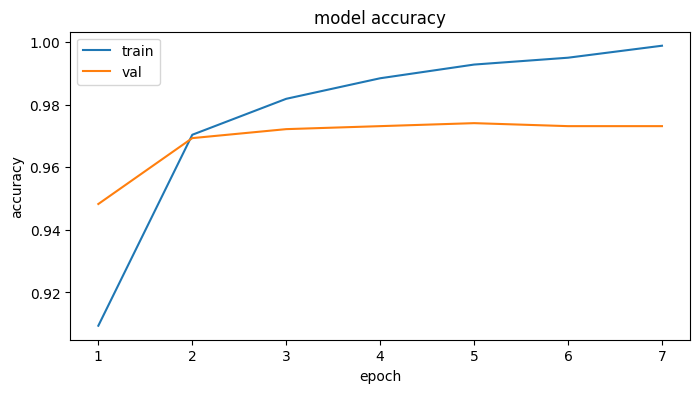

In [23]:
plt.figure(figsize=(8,4))
epochs=range(1,len(History.history['val_accuracy'])+1)

plt.plot(epochs,History.history["accuracy"])
plt.plot(epochs,History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

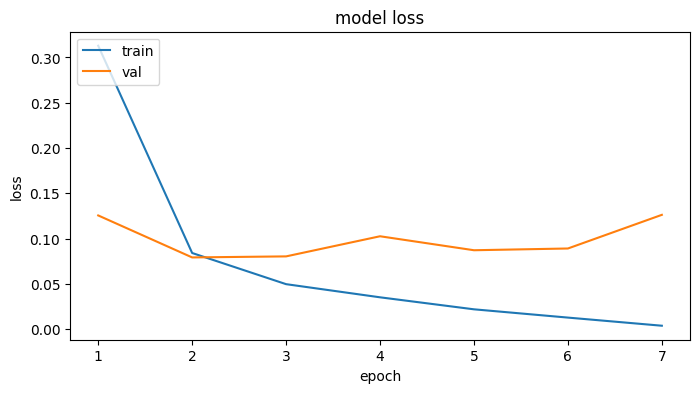

In [24]:
plt.figure(figsize=(8,4))
epochs=range(1,len(History.history['val_loss'])+1)

plt.plot(epochs,History.history["loss"])
plt.plot(epochs,History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
predict_classes = np.argmax(cnn.predict(test), axis= -1)

49/49 [==============================] - 26s 520ms/step


In [26]:
from sklearn.metrics import confusion_matrix
y_list = test_images['labels'].to_list()
y_test = []
for i in range(len(y_list)):
    if y_list[i] == 'normal':
        y_test.append(0)
    else:
        y_test.append(1)
y_test = np.array(y_test)
cm = confusion_matrix(y_test, predict_classes)
# cm = confusion_matrix(test_1, test_2)
cm

array([[ 411,   21],
       [  29, 1104]], dtype=int64)

In [27]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

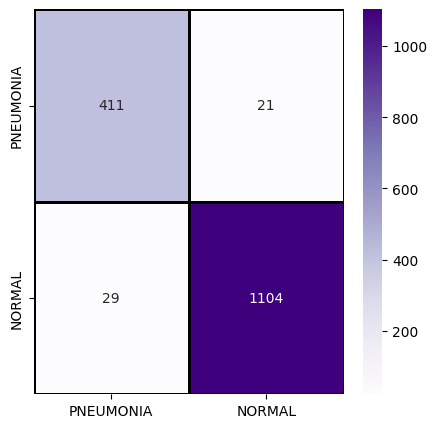

In [29]:
from keras.layers import Dense, Conv2D
plt.figure(figsize = (5,5))
sns.heatmap(cm ,cmap= "Purples", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)